## Introduction

In this notebook we will analyze and predict with machine learning models customer *churn* in a bank. 

The task is a typical **supervised binary classification** exercise. We want to determine if customers will stop using a company's products or services or will remain in the same company.

It is estimated that acquiring a new customer can cost up to **five times more** than retaining an existing one.


<br>



**What Is Churn Rate?**

The churn rate, also known as the rate of attrition or customer churn, is the rate at which customers stop doing business with an entity. It is most commonly expressed as the percentage of service subscribers who discontinue their subscriptions within a given time period. It is also the rate at which employees leave their jobs within a certain period. For a company to expand its clientele, its growth rate (measured by the number of new customers) must exceed its churn rate.






#### Import Libraries 📚


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install fast_ml --quiet
from fast_ml.model_development import train_valid_test_split


from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Define Color Palette 🎨

In [27]:
colors = [ '#ee6c4d', '#98c1d9', '#3d5a80', '#293241']
sns.set_palette(sns.color_palette(colors))

## Read Data 👓

The dataset contains a list of 10,000 clients of a bank with the following **attributes:**

* RowNumber
* CustomerId
* Surname
* CreditScore
* Geography
* Gender
* Tenure
* Balance
* NumOfProducts
* HasCrCard
* IsActiveMember
* EstimatedSalary

And the following **target:**
* Exited
    * 0: Customers Not Churned 
    * 1: Customers Churned



In [28]:
df = pd.read_csv("./data/churn.csv")

print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

df.head()

Rows: 10000
Columns: 14


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

### Very BASIC Cleaning 🧹

We do not want to contaminate our data or get insights before we divide into train, validation and test.

In [29]:
# Remove first column
df.drop(columns=['RowNumber'],inplace=True)

# Rename Exited column as: target
df = df.rename(columns={'Exited': 'target'})

# Set index to start from 1 to n
# df.index = np.arange(1,len(df)+1)
df.head()


CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   target  
0       1  
1       0  
2       1  
3       0  
4       0

### Separate Data into Train, Validation and Test ✂️

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*NQaN71ejH_eTUxhRLwiJcA.png" alt="drawing" width="450" height="300"/>

<!---
https://medium.com/@utkarsh.kant/how-to-split-your-dataset-into-train-test-and-validation-sets-17f40e98dfd0
-->





In [30]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df,
                                                                           target="target",
                                                                           train_size=0.6,
                                                                           valid_size=0.2,
                                                                           test_size=0.2)
# View size
print(X_train.shape,y_train.shape )
print(X_valid.shape,y_valid.shape )
print(X_test.shape,y_test.shape )


(6000, 12) (6000,)
(2000, 12) (2000,)
(2000, 12) (2000,)


## Exploratory Data Analysis 📈

All of our insights will be done in **train**. As mentioned earlier we do not want to peek and make assumptions with information from validation or test.

In [31]:
# Even though I call it df (for simplicity and convention) we should think of it as df_train in our head.

df = pd.concat([X_train, y_train],ignore_index=False,axis=1,sort=False)
df.head()

CustomerId Surname  CreditScore Geography  Gender  Age  Tenure  \
6665    15599024    Hope          506     Spain    Male   32       8   
5178    15794849  Aitken          850   Germany    Male   22       7   
1570    15607133    Shih          717     Spain  Female   49       1   
5972    15623499  Holman          548   Germany    Male   49       9   
2276    15684951      He          542    France  Female   59       2   

        Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
6665       0.00              2          0               1        182692.80   
5178   91560.58              2          0               0         10541.38   
1570  110864.38              2          1               1        124532.90   
5972  108437.89              1          0               0        127022.87   
2276   68892.77              2          1               0          7905.06   

      target  
6665       0  
5178       0  
1570       1  
5972       1  
2276       1

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 6665 to 7667
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       6000 non-null   int64  
 1   Surname          6000 non-null   object 
 2   CreditScore      6000 non-null   int64  
 3   Geography        6000 non-null   object 
 4   Gender           6000 non-null   object 
 5   Age              6000 non-null   int64  
 6   Tenure           6000 non-null   int64  
 7   Balance          6000 non-null   float64
 8   NumOfProducts    6000 non-null   int64  
 9   HasCrCard        6000 non-null   int64  
 10  IsActiveMember   6000 non-null   int64  
 11  EstimatedSalary  6000 non-null   float64
 12  target           6000 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 656.2+ KB


In [33]:
# Check for any NaN in df
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
target             0
dtype: int64

In [34]:
# Get general numerical information.
df.describe().T

count          mean           std          min          25%  \
CustomerId       6000.0  1.569000e+07  72244.966090  15565701.00  15627209.75   
CreditScore      6000.0  6.492317e+02     96.356123       350.00       583.00   
Age              6000.0  3.903300e+01     10.477669        18.00        32.00   
Tenure           6000.0  5.021167e+00      2.878153         0.00         3.00   
Balance          6000.0  7.611840e+04  62301.017803         0.00         0.00   
NumOfProducts    6000.0  1.526500e+00      0.581682         1.00         1.00   
HasCrCard        6000.0  7.120000e-01      0.452869         0.00         0.00   
IsActiveMember   6000.0  5.123333e-01      0.499890         0.00         0.00   
EstimatedSalary  6000.0  9.970537e+04  57969.023334        11.58     50202.46   
target           6000.0  2.078333e-01      0.405791         0.00         0.00   

                          50%           75%          max  
CustomerId       1.568912e+07  1.575323e+07  15815690.00  
CreditScore      6.510000e+02  7.160000e+02       850.00  
Age              3.700000e+01  4.400000e+01        92.00  
Tenure           5.000000e+00  7.000000e+00        10.00  
Balance          9.640114e+04  1.275372e+05    238387.56  
NumOfProducts    1.000000e+00  2.000000e+00         4.00  
HasCrCard        1.000000e+00  1.000000e+00         1.00  
IsActiveMember   1.000000e+00  1.000000e+00         1.00  
EstimatedSalary  1.001939e+05  1.491078e+05    199992.48  
target           0.000000e+00  0.000000e+00         1.00

In [35]:
df['Geography'].unique()

array(['Spain', 'Germany', 'France'], dtype=object)

### Numerical Features vs. Target

Plot numerical features vs target to see if we can get any insights.

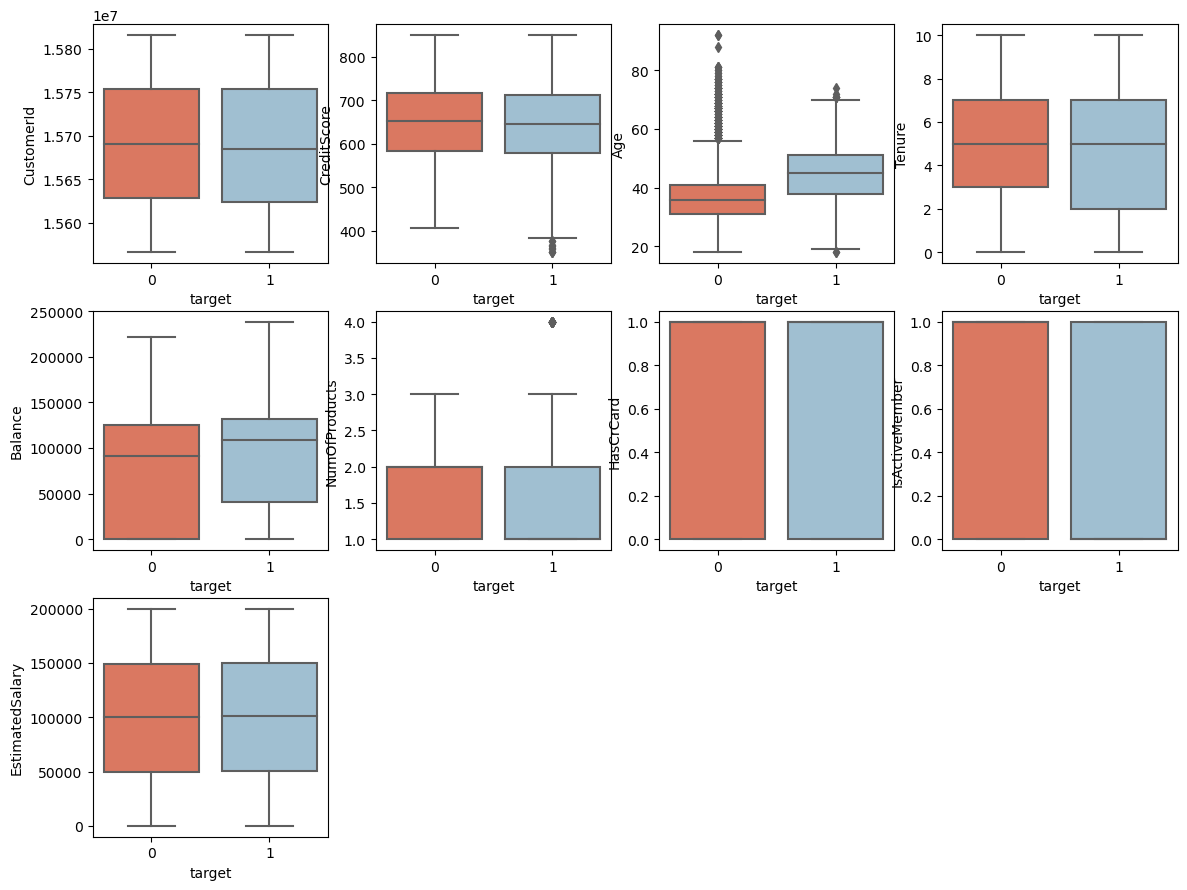

In [44]:
# BOX PLOT

cat_list= ["CustomerId", "CreditScore",	"Age","Tenure", "Balance",	"NumOfProducts","HasCrCard", "IsActiveMember","EstimatedSalary"]
fig = plt.figure(figsize =(14,18))

for i in range(len(cat_list)):
    column = cat_list[i]
    sub = fig.add_subplot(5,4,i+1)
    sns.boxplot( x = "target", y = column, data = df)

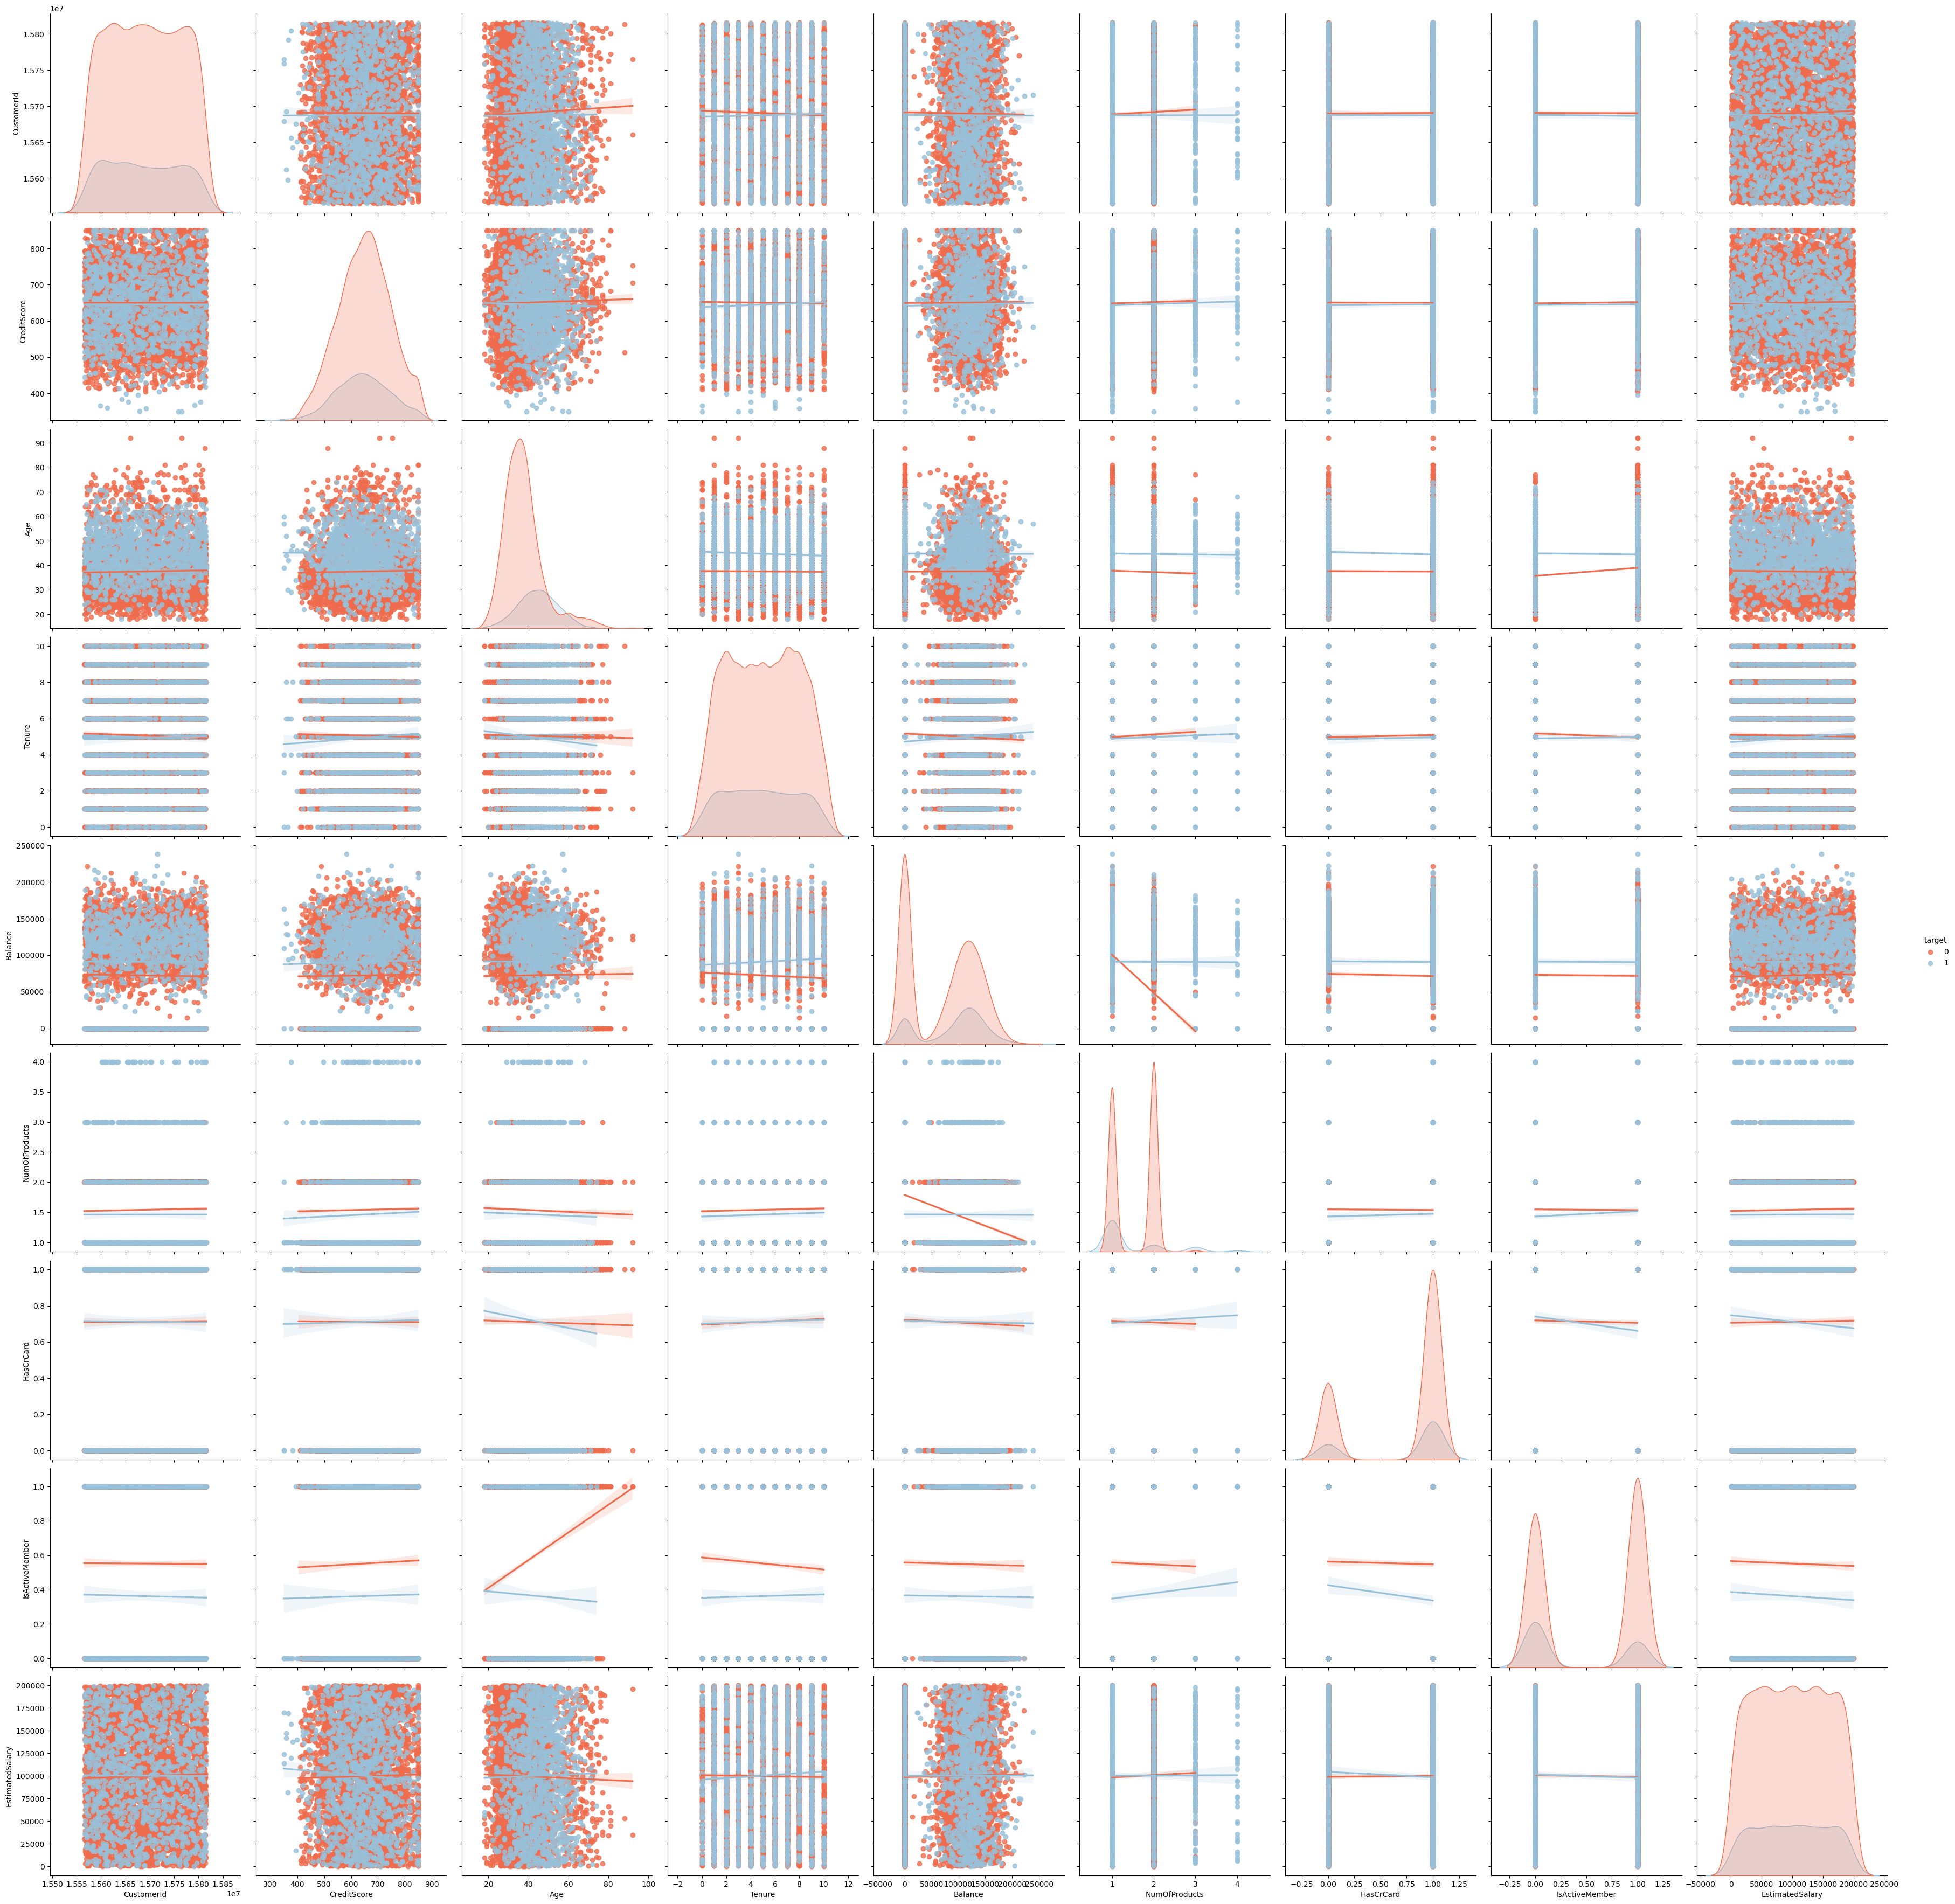

In [37]:
# PAIR PLOT

num_columns = ["CustomerId","CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]

sns.pairplot(df,
             hue='target',
             height=4,
             vars=num_columns,
             kind="reg");

## Check Outliers

Even though in the future outliers may be present we prefer to fit our model without taking them into account as the model will predict better.

We must look in our dataset just in case they exist and analyze them to find out what to do with them.

From the following graphs we can see that there are 3 attributes that have noticeable outliers: 👀
* **CreditScore**
* **Age**
* **NumOfProducts**


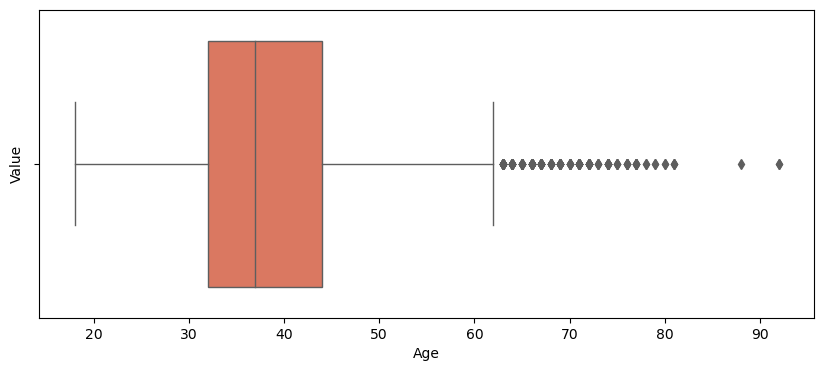

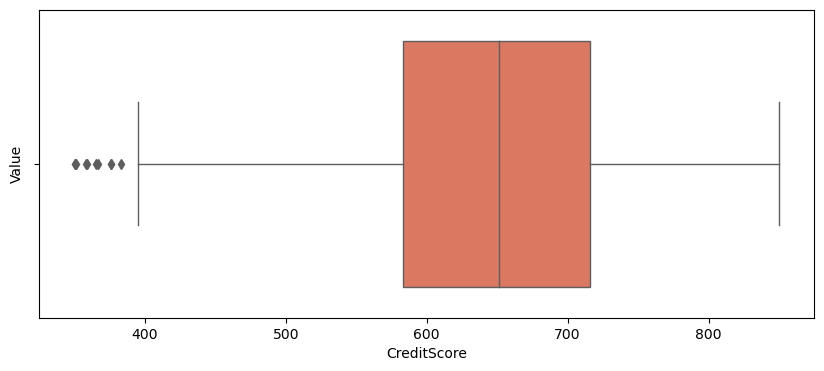

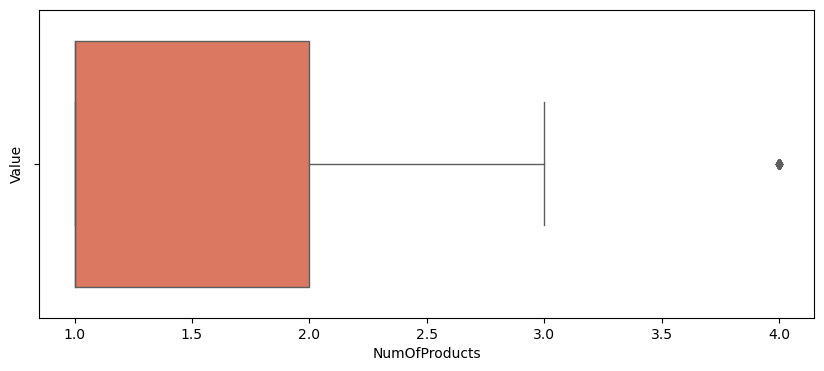

In [45]:
# For simplicity we will only plot the 3 most noticeable. 
cat_list= ["Age", "CreditScore", "NumOfProducts"]

# All numerical attributes
# cat_list= ["Age", "CreditScore", "NumOfProducts", "CustomerId", "Tenure", "Balance", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

for i in cat_list:
    fig, ax_box = plt.subplots(figsize=(10, 4))
    sns.boxplot(df[i], ax=ax_box, linewidth=1.0, palette=colors)
    ax_box.set_xlabel(i)
    ax_box.set_ylabel('Value')
    plt.show(block=False)
    plt.pause(0.1)
    plt.close(fig)

In [40]:
# We will remove certain outliers without removing too many samples. 
# Remember we have a sample of 6,000 rows in our train dataframe.
len(df)

6000

### Box Plot Refresh

<img src="https://www.simplypsychology.org/wp-content/uploads/boxplot-outliers.png" width=800 height=400>



The Interquartile Range of the data is calculated:
    
    IQR = Q3 — Q1

In [48]:
Q1 = df["Age"].quantile(0.25)
Q3 = df["Age"].quantile(0.75)
IQR = Q3 - Q1



44.0

In [46]:
# Remove 75% and above
Q3 = df['Age'].quantile(0.75)
df_outlier_age_removed = df[df['Age'] <= Q3]
len(df_outlier_age_removed)

4573

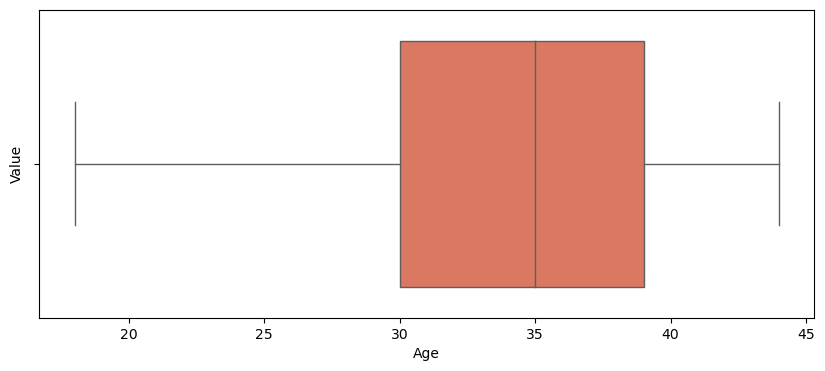

In [47]:
# For simplicity we will only plot the 3 most noticeable. 
cat_list= ["Age"]

# All numerical attributes
# cat_list= ["Age", "CreditScore", "NumOfProducts", "CustomerId", "Tenure", "Balance", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

for i in cat_list:
    fig, ax_box = plt.subplots(figsize=(10, 4))
    sns.boxplot(df_outlier_age_removed[i], ax=ax_box, linewidth=1.0, palette=colors)
    ax_box.set_xlabel(i)
    ax_box.set_ylabel('Value')
    plt.show(block=False)
    plt.pause(0.1)
    plt.close(fig)

In [ ]:
aass

NameError: name 'aass' is not defined

In [ ]:
for col in df.columns[df.dtypes == "float64"]:
    df[col] = df[col].astype("int64")


### Is Our Data Balanced ?

Most machine learning algorithms work best when the number of samples in each class is about equal. This is because most algorithms are designed to maximize accuracy and reduce errors.

If the dataframe has imbalanced classes you get a pretty high accuracy just by predicting the **majority class**, but you fail to capture the **minority class**, which is most often the point of creating the model in the first place. 


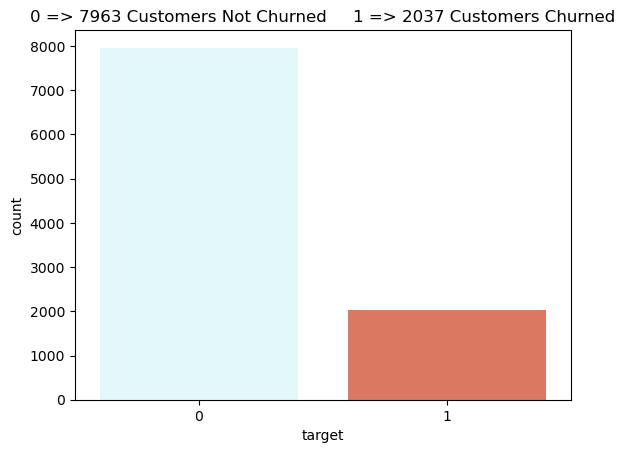

In [ ]:
# In this example we can see that there is quite a big difference.
x, y  = df["target"].value_counts()

title = "0 => "+ str(x)+ " Customers Not Churned     1 => "+str(y)+ " Customers Churned"

sns.countplot(x="target", data=df).set(title=title)
plt.show()

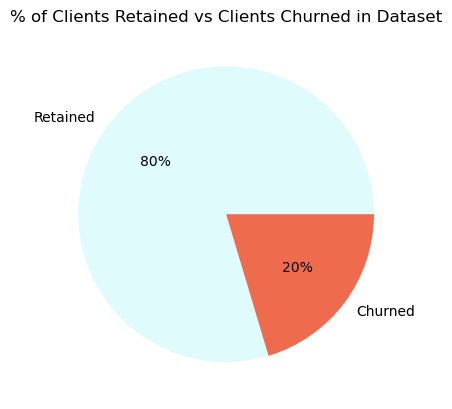

In [ ]:
# Show as %
x, y  = df["target"].value_counts()

# plotting data on chart
plt.pie([x,y], labels=["Retained","Churned"], autopct='%.0f%%')
  
# displaying chart
plt.title("% of Clients Retained vs Clients Churned in Dataset")
plt.show()

### Balance Data by Random Under-Sample

From the above graph we can see that if we didn´t bother to train a model and just create a function that tells us that the client will not leave we would be 80% accurate!

This accuracy would be **misleading** as your overall accuracy would be high simply because most of the customers will not change bank.

Since our dataset is sufficiently large ( 7,963 retained clients vs 2,037 churned clients), we will **drop retained clients** in order to later make better predictions with our machine learning models.

Remember, that the **drawback** of undersampling is that we may **remove information** that may be **valuable.** We are supposing that having at least >1,000 different clients who are retained and churned is sufficient. We will actually end up with 4,074 clients (2,037 clients of each group).

In [ ]:
# Remember how our df looked.
df.head()

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   target  
0       1  
1       0  
2       1  
3       0  
4       0

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(df.loc[:, 'CustomerId':'EstimatedSalary'], df['target'])
X_rus # We have 4074 rows (2,037 x 2) Same amount of 0 and 1

CustomerId      Surname  CreditScore Geography  Gender  Age  Tenure  \
0       15813503    Pickering          606     Spain    Male   37       8   
1       15690695        Flynn          683    France  Female   33       9   
2       15750649       Uwakwe          744    France  Female   44       3   
3       15662955     Nicholls          697    France    Male   27       8   
4       15755868       Farmer          562    France    Male   35       7   
...          ...          ...          ...       ...     ...  ...     ...   
4069    15672754     Burbidge          498   Germany    Male   42       3   
4070    15768163      Griffin          655   Germany  Female   46       7   
4071    15769959  Ajuluchukwu          597    France  Female   53       4   
4072    15584532          Liu          709    France  Female   36       7   
4073    15682355    Sabbatini          772   Germany    Male   42       3   

        Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0     154712.58              2          1               0         89099.18  
1          0.00              2          1               1         38784.42  
2          0.00              2          1               1        189016.14  
3     141223.68              2          1               0         90591.15  
4          0.00              1          0               0         48869.67  
...         ...            ...        ...             ...              ...  
4069  152039.70              1          1               1         53445.17  
4070  137145.12              1          1               0        115146.40  
4071   88381.21              1          1               0         69384.71  
4072       0.00              1          0               1         42085.58  
4073   75075.31              2          1               0         92888.52  

[4074 rows x 12 columns]

Text(0.5, 1.0, 'Random Under-Sampling')

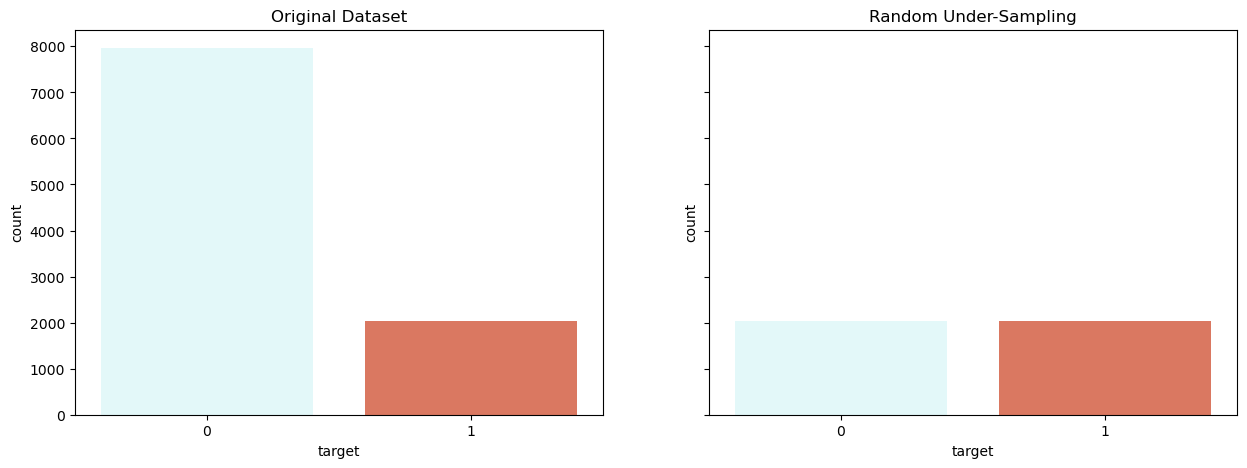

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Original target
sns.countplot(x="target", data=df, ax=axes[0])
axes[0].set_title("Original Dataset")

# RandomUnderSampler
sns.countplot(y_rus, ax=axes[1])
axes[1].set_title("Random Under-Sampling")


In [ ]:
df

CustomerId    Surname  CreditScore Geography  Gender  Age  Tenure  \
0       15634602   Hargrave          619    France  Female   42       2   
1       15647311       Hill          608     Spain  Female   41       1   
2       15619304       Onio          502    France  Female   42       8   
3       15701354       Boni          699    France  Female   39       1   
4       15737888   Mitchell          850     Spain  Female   43       2   
...          ...        ...          ...       ...     ...  ...     ...   
9995    15606229   Obijiaku          771    France    Male   39       5   
9996    15569892  Johnstone          516    France    Male   35      10   
9997    15584532        Liu          709    France  Female   36       7   
9998    15682355  Sabbatini          772   Germany    Male   42       3   
9999    15628319     Walker          792    France  Female   28       4   

        Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0          0.00              1          1               1        101348.88   
1      83807.86              1          0               1        112542.58   
2     159660.80              3          1               0        113931.57   
3          0.00              2          0               0         93826.63   
4     125510.82              1          1               1         79084.10   
...         ...            ...        ...             ...              ...   
9995       0.00              2          1               0         96270.64   
9996   57369.61              1          1               1        101699.77   
9997       0.00              1          0               1         42085.58   
9998   75075.31              2          1               0         92888.52   
9999  130142.79              1          1               0         38190.78   

      target  
0          1  
1          0  
2          1  
3          0  
4          0  
...      ...  
9995       0  
9996       0  
9997       1  
9998       1  
9999       0  

[10000 rows x 13 columns]

In [ ]:
y_rus

0       0
1       0
2       0
3       0
4       0
       ..
4069    1
4070    1
4071    1
4072    1
4073    1
Name: target, Length: 4074, dtype: int64

In [ ]:
new_df = pd.concat([X_rus, y_rus],ignore_index=False,axis=1,sort=False)
new_df

CustomerId      Surname  CreditScore Geography  Gender  Age  Tenure  \
0       15813503    Pickering          606     Spain    Male   37       8   
1       15690695        Flynn          683    France  Female   33       9   
2       15750649       Uwakwe          744    France  Female   44       3   
3       15662955     Nicholls          697    France    Male   27       8   
4       15755868       Farmer          562    France    Male   35       7   
...          ...          ...          ...       ...     ...  ...     ...   
4069    15672754     Burbidge          498   Germany    Male   42       3   
4070    15768163      Griffin          655   Germany  Female   46       7   
4071    15769959  Ajuluchukwu          597    France  Female   53       4   
4072    15584532          Liu          709    France  Female   36       7   
4073    15682355    Sabbatini          772   Germany    Male   42       3   

        Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0     154712.58              2          1               0         89099.18   
1          0.00              2          1               1         38784.42   
2          0.00              2          1               1        189016.14   
3     141223.68              2          1               0         90591.15   
4          0.00              1          0               0         48869.67   
...         ...            ...        ...             ...              ...   
4069  152039.70              1          1               1         53445.17   
4070  137145.12              1          1               0        115146.40   
4071   88381.21              1          1               0         69384.71   
4072       0.00              1          0               1         42085.58   
4073   75075.31              2          1               0         92888.52   

      target  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
4069       1  
4070       1  
4071       1  
4072       1  
4073       1  

[4074 rows x 13 columns]

## Machine Learning